In [164]:
from collections import Counter
from datetime import datetime, timedelta as td
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

dtf = datetime.strftime
dtp = datetime.strptime

In [120]:
class ExpLogHandler:
    def __init__(self, log_names):
        self.log_names = log_names
        
    def getData(self):
        self.data = pd.read_csv(self.log_names[0], error_bad_lines=False)
        for i in range(1, len(self.log_names)):
            data_next   = pd.read_csv(self.log_names[i], error_bad_lines=False)
            data_frames = [self.data, data_next]
            self.data   = pd.concat(data_frames, ignore_index=True)
        self.data.drop(self.data.loc[(self.data["Timestamp"] == "Timestamp")].index.tolist())
        self.dataLength = self.data.shape[0]

        wrchckbrdLocs  = self.data.loc[(self.data["Board"] == "M") & (self.data["Mikroe_socket"] == "A") &
                                       (self.data["Status"] == "WRCHCKBRD")].index.tolist()
        wrchckbrdIndex = [(i, "WRCHCKBRD") for i in wrchckbrdLocs]
        initLocs       = self.data.loc[(self.data["Board"] == "M") & (self.data["Mikroe_socket"] == "A") &
                         (self.data["Status"] == "INIT")].index.tolist()
        initIndex      = [(i, "INIT") for i in initLocs]
        runIndex       = wrchckbrdIndex + initIndex
        runIndex       = sorted(runIndex)
        runIndex.append((self.dataLength, "END"))
        
        runId  = 1
        runCol = [''] * self.dataLength
        for h in range(len(runIndex) - 1):
            if runIndex[h][1] == "WRCHCKBRD":
                start              = runIndex[h][0]
                end                = runIndex[h+1][0]
                runCol[start:end]  = [runId]*(end-start)
                runId              += 1

        self.data.insert(loc=0, column="Run_ID", value=runCol)
        return self.data

In [121]:
class BeamLogHandler:
    def __init__(self, firstTime, lastTime, targetDir_fullpathList):     
        self.beamLogFnameFormat          = "%Y-%m-%d"
        self.firstTime                   = firstTime
        self.lastTime                    = lastTime
        self.targetDir_fullpathList      = targetDir_fullpathList
        self.targetDir_fullpathList[-4:] = ["neutrons"]

    def getLogs(self):
        firstBeamTime = dtf(self.firstTime, self.beamLogFnameFormat)
        beamlogDayDif = (self.lastTime - self.firstTime).days
        beamPath      = "../../../neutrons/countlog-"
        self.beamlog  = pd.read_csv(f"{beamPath}{firstBeamTime}.txt",
                        delim_whitespace=True, header=None, skiprows=1)
        nextTime      = self.firstTime
        for i in range(0, beamlogDayDif+1):
            nextTime      = nextTime + td(days=1)
            nextBeamTime  = dtf(nextTime, self.beamLogFnameFormat)
            try:
                nextBeamlog   = pd.read_csv(f"{beamPath}{nextBeamTime}.txt",delim_whitespace=True,header=None,skiprows=1)
            except FileNotFoundError:
                pass
            beamlogFrames = [self.beamlog, nextBeamlog]
            self.beamlog  = pd.concat(beamlogFrames, ignore_index=True)
            
        self.beamlog.columns = ["Date","HMS_time","Millisecs","Count1","Count2",
                                "Count3","Count4","protonCharge","Beam_current"]
        return self.beamlog

In [122]:
class Run:
    def __init__(self, num, runData):
        self.delay     = -1
        self.df        = runData
        self.errors    = 0
        self.fullErr   = -1
        self.hot       = -1
        self.num       = num
        self.rowErr    = -1
        self.see       = -1
        self.valid     = -1
        self.aErrorsNVRAM = []
        self.bErrorsNVRAM = []
        self.cErrorsNVRAM = []
        self.dErrorsNVRAM = []

In [123]:
class Analyser:
    def __init__(self, targetDir_fullpath):
        self.targetDir_fullpath  = targetDir_fullpath
        self.expLogTstampFormat  = "%Y-%m-%d_%H-%M-%S-%f"
        self.beamLogTstampFormat = "%d/%m/%Y %H:%M:%S"
 
    def setup(self):
        targetDir_fullpathList = self.targetDir_fullpath.split("/")
        targetDir_trunc        = targetDir_fullpathList[-3:]
        self.chip              = targetDir_trunc[0]
        self.variant           = targetDir_trunc[1]
        self.size              = targetDir_trunc[2]

        # Get data from logs
        self.log_names     = [self.targetDir_fullpath+i for i in os.listdir(self.targetDir_fullpath) if ".csv" in i]
        self.log_names.sort(key = lambda x: dtp(x, f"{self.targetDir_fullpath}nvRAM_data_%d-%m-%Y-%H%M.csv"))
        self.ExpLogHandler = ExpLogHandler(self.log_names)
        self.data          = self.ExpLogHandler.getData()

        # Get beam status from logs
        firstTimestamp      = self.data[0:1]['Timestamp'][0]
        lastTimestamp       = self.data[self.data.shape[0]-2:self.data.shape[0]-1]['Timestamp'][self.data.shape[0]-2]
        firstTime           = dtp(firstTimestamp, self.expLogTstampFormat)
        lastTime            = dtp(lastTimestamp, self.expLogTstampFormat)
        self.BeamLogHandler = BeamLogHandler(firstTime, lastTime, targetDir_fullpathList)
        self.beamlog        = self.BeamLogHandler.getLogs()

        # Create datetime objects from beamlog timestamps
        beamlogTstamps    = (self.beamlog['Date']+self.beamlog['HMS_time']+self.beamlog['Millisecs'].apply(str)).tolist()
        self.beamlogTimes = []
        for i in beamlogTstamps:
            if len(i) > 23:
                i = i[0:26]
            self.beamlogTimes.append(i)
        self.beamlogTimes = [dtp(i, '%d/%m/%Y%H:%M:%S0.%f') for i in self.beamlogTimes]

    def beamOn(self, firstTstamp, lastTstamp):
        bOfirstTime = firstTstamp
        bOlastTime = lastTstamp
        beamTimeNearFirstTime = min([i for i in self.beamlogTimes if i <= bOfirstTime], key=lambda x: abs(x - bOfirstTime))
        beamTimeNearLastTime  = min([i for i in self.beamlogTimes if i >= bOlastTime], key=lambda x: abs(x - bOlastTime))
        firstRow              = self.beamlog.loc[(self.beamlog['Date'] == dtf(beamTimeNearFirstTime, '%d/%m/%Y')) &
                                (self.beamlog['HMS_time'] == dtf(beamTimeNearFirstTime, '%H:%M:%S'))]
        lastRow               = self.beamlog.loc[(self.beamlog['Date'] == dtf(beamTimeNearLastTime, '%d/%m/%Y')) & 
                                (self.beamlog['HMS_time'] == dtf(beamTimeNearLastTime, '%H:%M:%S'))]
        count4Dif             = lastRow.iloc[0]['Count4'] - firstRow.iloc[0]['Count4']
        numRows               = lastRow.index.astype(int)[0] - firstRow.index.astype(int)[0]
        cps                   = count4Dif / numRows
        if cps > 1:
            return 1
        return 0

    def createRuns(self):
        runNames  = []
        self.runs = {}
        lastRunID =  self.data[self.data['Run_ID'].last_valid_index():self.data['Run_ID']. \
                    last_valid_index()+1]['Run_ID'][self.data['Run_ID'].last_valid_index()]

        # Supply Run initialiser with truncated data 
        for i in range(1, lastRunID + 1):
            runNames.append(f"run_{i}")
            runData      = self.data.loc[(self.data["Run_ID"] == i)]
            runData.reset_index(inplace=True, drop=True)
            self.runs[i] = Run(i, runData)

        for run in self.runs.values():
            try:
                # Extract beam delay from timestamps
                before_delay_i  = run.df.loc[(run.df['Mikroe_socket']=='D') & (run.df['Status']=='STORE_OK')].index[0]
                before_delay_t  = run.df.loc[before_delay_i]['Timestamp']
                after_delay_i   = run.df.loc[(run.df['Mikroe_socket']=='A') & (run.df['Status']=='VERIF')].index[0]+1
                after_delay_t   = run.df.loc[after_delay_i]['Timestamp']
                before_delay_dt = dtp(before_delay_t, self.expLogTstampFormat)
                after_delay_dt  = dtp(after_delay_t, self.expLogTstampFormat)   
                dif             = after_delay_dt - before_delay_dt
                if td(seconds = 0.1) < dif < td(seconds = 0.5):
                    run.delay = 0.1
                if td(seconds = 0.5) < dif < td(seconds = 5):
                    run.delay = 1
                if td(seconds = 5) < dif < td(seconds = 50):
                    run.delay = 10
                if td(seconds = 50) < dif < td(seconds = 500):
                    run.delay = 100
                if td(seconds = 500) < dif < td(seconds = 5000):
                    run.delay = 1000

                # Was the beam on?
                try:
                    if self.beamOn(before_delay_dt, after_delay_dt):
                        run.hot = 1
                    else:
                        run.hot = 0
                except ValueError:
                    print(run.name)
                    
                # try:
                #     run.errors = run.df['Status'].value_counts()['SDC']
                # except KeyError:
                #     run.errors = 0

                # Create list of errors in nvRAM per chip

                aErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                       (run.df["Status"] == "VERIF")].index.tolist(),
                                        run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                       (run.df["Status"] == "VERIF_OK")].index.tolist()))

                bErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "B") & 
                                       (run.df["Status"] == "VERIF")].index.tolist(),
                                        run.df.loc[(run.df["Mikroe_socket"] == "B") &
                                       (run.df["Status"] == "VERIF_OK")].index.tolist()))

                cErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                       (run.df["Status"] == "VERIF")].index.tolist(),
                                        run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                       (run.df["Status"] == "VERIF_OK")].index.tolist()))

                dErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                       (run.df["Status"] == "VERIF")].index.tolist(),
                                        run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                       (run.df["Status"] == "VERIF_OK")].index.tolist()))

                aErrorsBefRec = list(zip(run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                         run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                aErrorsAftRec = list(zip(run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                         run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                bErrorsBefRec = list(zip(run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                         run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                bErrorsAftRec = list(zip(run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                         run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                cErrorsBefRec = list(zip(run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                         run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                cErrorsAftRec = list(zip(run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                         run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                dErrorsBefRec = list(zip(run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                         run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                dErrorsAftRec = list(zip(run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                         run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_loc"].values.tolist())) 
                
                run.aErrorsNVRAM = [i for i in aErrorsAftRec if i not in aErrorsBefRec if np.nan not in i]
                run.bErrorsNVRAM = [i for i in bErrorsAftRec if i not in bErrorsBefRec if np.nan not in i]
                run.cErrorsNVRAM = [i for i in cErrorsAftRec if i not in cErrorsBefRec if np.nan not in i]
                run.dErrorsNVRAM = [i for i in dErrorsAftRec if i not in dErrorsBefRec if np.nan not in i]

                run.errors += len(run.aErrorsNVRAM)
                run.errors += len(run.bErrorsNVRAM)
                run.errors += len(run.cErrorsNVRAM)
                run.errors += len(run.dErrorsNVRAM)

            # Invalidate run if critical experiment steps didn't occur
            except IndexError:
                run.valid = 0
            else:
                run.valid = 1

In [124]:
sram3_1_half = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/SRAM3/1/half/")

In [125]:
sram3_1_half.setup()

In [126]:
sram3_1_half.createRuns()

Need to deal with runs where experiment restarts during it

In [127]:
runs_with_err = []
for run in sram3_1_half.runs.values():
    if run.errors:
        runs_with_err.append(run.num)

In [128]:
runs_with_nvram_err = []
for run in sram3_1_half.runs.values():
        if run.aErrorsNVRAM:
            runs_with_nvram_err.append(run.num)
        elif run.bErrorsNVRAM:
            runs_with_nvram_err.append(run.num)
        elif run.cErrorsNVRAM:
            runs_with_nvram_err.append(run.num)
        elif run.dErrorsNVRAM:
            runs_with_nvram_err.append(run.num)

In [129]:
len(runs_with_nvram_err)

446

In [142]:
sram3_1_half.runs[466].errors

2

In [146]:
sram3_1_half.runs[466].dErrorsNVRAM

[('AB', '6C2A')]

In [168]:
runErrorsRanked = []
for run in sram3_1_half.runs.values():
    if run.errors:
        runErrorsRanked.append((run.num, run.errors))

runErrorsRanked.sort(reverse=True, key=lambda i: i[1])

Plot the number of flipped bits per neutron event across the current data.

Text(0, 0.5, 'Single event effects')

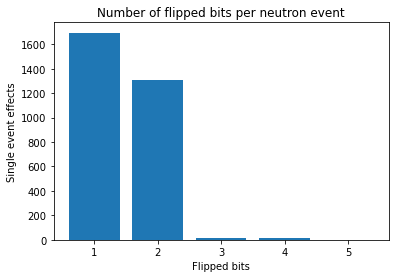

In [173]:
goldbyte = 170
hamDistList = []
ignores = [1593, 1512, 1547, 27, 455]
for run in sram3_1_half.runs.values():
    if run.num not in ignores:
        if run.errors:
            for error in run.aErrorsNVRAM:
                hamDist = bin(int(error[0], 16) ^ goldbyte).count('1')
                hamDistList.append(hamDist)

hamDistDict = Counter(hamDistList)
plt.bar(hamDistDict.keys(), hamDistDict.values())
plt.title("Number of flipped bits per neutron event")
plt.xlabel("Flipped bits")
plt.ylabel("Single event effects")